## Trabalho de Sistemas Embarcados 2

Infelizmente não foi possível realizar todo o trabalho mas deixo aqui o que foi possível de ser feito, minha maior dificuldade foi realizar a parte da simulação da resposta do sistema ao controlador, logo nem tentei fazer a parte do servidor.

## Bibliotecas

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
# https://python-control.readthedocs.io/en/latest/matlab.html#matlab-module
from control.matlab import *

## Modelagem

In [2]:
s = tf('s')
m = 0.150
g = 9.81
Ca = 0.5
rho = 1
r = 0.1
A = np.pi * r ** 2
alfa = 0.5 * Ca * rho * A / m
va_e = np.sqrt(g / alfa)
k_m = 0.5
tal = 0.01
Gb = (2 * alfa * va_e) / (s ** 2)  # Ft do movimento da bolinha
Gv = k_m / (tal * s + 1)  # Ft da ventoinha
G = Gv * Gb
Gs = tf2ss(G)


h = 1e-4
uk = np.array([0])
xk = np.array([[1], [0], [0]])
tensao = 0

In [3]:
print(G)


    0.7167
--------------
0.01 s^3 + s^2



In [4]:
# Conversão para a representação no espaço de estados
Gss = tf2ss(G)
print(Gss)

A = [[-100.   -0.   -0.]
     [   1.    0.    0.]
     [   0.    1.    0.]]

B = [[1.]
     [0.]
     [0.]]

C = [[ 0.          0.         71.66940762]]

D = [[0.]]



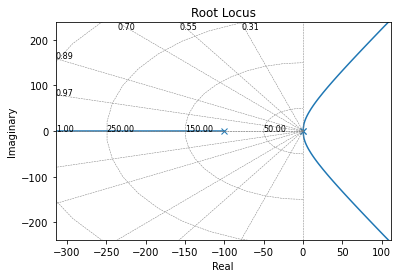

In [5]:
rlist, klist = rlocus(G)

In [6]:
# Conversão para o sistema de tempo discreto
Ts = 0.01
Gd = c2d(G,Ts,method='tustin')
print(Gd)


5.972e-06 z^3 + 1.792e-05 z^2 + 1.792e-05 z + 5.972e-06
-------------------------------------------------------
          z^3 - 2.333 z^2 + 1.667 z - 0.3333

dt = 0.01



--> P 
50
--
1

dt = 0.01
 
--> I 
2 z + 2
-------
 z - 1

dt = 0.01
 
--> D 
5e+06 z - 5e+06
---------------
     z + 1

dt = 0.01


--> PID 
5e+06 z^2 - 1e+07 z + 5e+06
---------------------------
          z^2 - 1

dt = 0.01



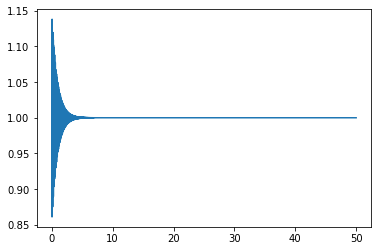

In [7]:
# PID
Kp = 50;
Ki = 400;
Kd = 25000;

P = tf([Kp],[1], Ts)
I = (Ki*Ts/2)*tf([1,1],[1,-1],Ts)
D = (2*Kd/Ts)*tf([1,-1],[1,1],Ts)

print('--> P', P, '\n--> I', I, '\n--> D', D)
Cz = P + I + D
print('\n--> PID',Cz)
T = feedback(Cz*Gd)
yout, tout = step(T)
plt.plot(tout,yout)

## Controlador PID

In [8]:
def x_dot(t, x, u):
    A = Gs.A
    B = Gs.B
    xkp1 = A @ x + B @ u
    return xkp1

In [9]:
#Runge Kutta de 4ª órdem
def rk4(self, tk, xk, uk):
    h = 1e-4
    xk = xk.reshape([3, 1])
    uk = uk.reshape([1, 1])
    k1 = x_dot(tk, xk, uk)
    k2 = x_dot(tk + h / 2.0, xk + h * k1 / 2.0, uk)
    k3 = x_dot(tk + h / 2.0, xk + h * k2 / 2.0, uk)
    k4 = x_dot(tk + h, xk + h * k3, uk)
    xkp1 = xk + (h / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xkp1.reshape([3,])

In [10]:
from scipy import signal
# PARÂMETROS DE SIMULAÇÃO
h = 1e-4
Ts = 0.01
maxT = 100
mult = Ts/h
t = np.arange(0,maxT,h)
tu = np.arange(0,maxT,Ts)

# Vetor de estados
x = np.zeros([3, len(t)])
# Vetor de controle
 
r = (np.ones([len(t)-1])*0.5) - (0.25*signal.square(2 *3.14 *(1/120) * len(t)))
#r = np.ones([len(t)-1])*0.5
u = np.ones([len(tu)])
y = np.zeros([len(t)-1])

In [11]:
# Execução da simulação
tam = len(t) - 1
# Matriz de medidas
C = np.array([1, 0 , 0]).reshape([1,3])
# Dados do controlador
# PID
Kp = 50;
Ki = 400;
Kd = 25000;
ek_1 = 0
uk_1 = 0
p = 0

for k in range(tam - 1):
    # Saída
    y[k] = C @ x[:,k]
    
    if (k % mult) == 0:
        # Erro de controle
        ek = r[k] - y[k]
        
        # Entrada de Controle
        u[p] = Kp*ek + uk_1 + Ki*(ek+ek_1)-uk_1+Kd*(ek-ek_1)# Ts = 0.01
        
        u[p] = u[p]+va_e
    
        #Limitador de Tensão
        vmax =100;
        if u[p] > vmax:
            u[p] = vmax
        elif u[p] < 0:
            u[p] = 0
        # Atualização das medidas passadas
        ek_1 = ek
        uk_1 = u[p]
        p = p + 1
    # Simulação um passo a frente

    x[:,k+1] = rk4(t[k], h, x[:,k], u[p-1])

Text(0.5, 0, 't [s]')

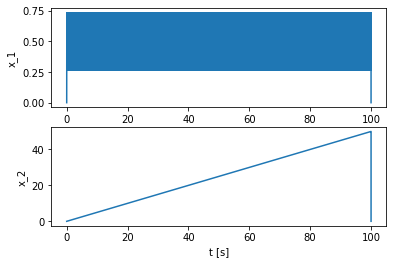

In [12]:
plt.subplot(2, 1, 1)
plt.plot(t,x[0,:])
plt.ylabel('x_1')
plt.subplot(2, 1, 2)
plt.plot(t,x[1,:])
plt.ylabel('x_2')
plt.xlabel('t [s]')

In [13]:
# # Ajuste de dimensões
# print(len(t),len(u),len(y))
# r = r[0:-1]
# y = y[0:-1]
# print(len(t),len(r),len(y))

Text(0.5, 0, 'Tempo (t [s])')

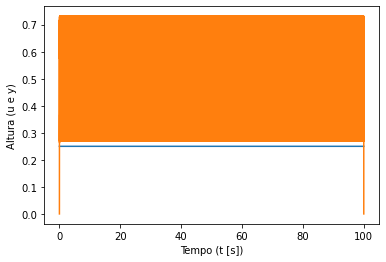

In [14]:
plt.plot(t[0:-1],r)
plt.plot(t[0:-1],y)
plt.ylabel('Altura (u e y)')
plt.xlabel('Tempo (t [s])')


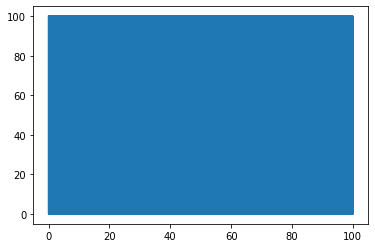

In [15]:
#print(len(u),len(tu))
plt.plot(tu[0:len(u)],u)